# Libraries

In [85]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import demoji
from tqdm import tqdm
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import pickle

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from tensorflow.keras.regularizers import l2

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yeohz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\yeohz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yeohz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Preperation

#### Peek Data

In [34]:
df = pd.read_csv("../Dataset/Suicide_Detection.csv")
df

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


#### Check Null

In [36]:
df["text"].isnull().sum()

0

#### Class Balance

In [35]:
df["class"].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

Suicide and non-suicide text are equal in number.

#### Add space to some camel cased words

In [37]:
df['text'] = df['text'].replace(r"(\w)([A-Z])", r"\1 \2", regex=True)
df['text']

0         Ex Wife Threatening Suicide Recently I left my...
1         Am I weird I don't get affected by compliments...
2         Finally 2020 is almost over... So I can never ...
3                 i need helpjust help me im crying so hard
4         I’m so lost Hello, my name is Adam (16) and I’...
                                ...                        
232069    If you don't like rock then your not going to ...
232070    You how you can tell i have so many friends an...
232071    pee probably tastes like salty tea😏💦‼️ can som...
232072    The usual stuff you find here I'm not posting ...
232073    I still haven't beaten the first boss in Hollo...
Name: text, Length: 232074, dtype: object

#### Convert Emojis into Text

In [39]:
def emoji_to_text(text):
    return demoji.replace_with_desc(text, " ")

In [40]:
tqdm.pandas(desc="Progress Bar: ")
df["text"] = df["text"].progress_apply(emoji_to_text)

Progress Bar: 100%|███████████████████████████████████████████████████████████| 232074/232074 [22:55<00:00, 168.69it/s]


In [41]:
df["text"]

0         Ex Wife Threatening Suicide Recently I left my...
1         Am I weird I don't get affected by compliments...
2         Finally 2020 is almost over... So I can never ...
3                 i need helpjust help me im crying so hard
4         I’m so lost Hello, my name is Adam (16) and I’...
                                ...                        
232069    If you don't like rock then your not going to ...
232070    You how you can tell i have so many friends an...
232071    pee probably tastes like salty tea smirking fa...
232072    The usual stuff you find here I'm not posting ...
232073    I still haven't beaten the first boss in Hollo...
Name: text, Length: 232074, dtype: object

#### Lowercase alphabets

In [43]:
df["text"] = df["text"].str.lower()

In [44]:
df["text"]

0         ex wife threatening suicide recently i left my...
1         am i weird i don't get affected by compliments...
2         finally 2020 is almost over... so i can never ...
3                 i need helpjust help me im crying so hard
4         i’m so lost hello, my name is adam (16) and i’...
                                ...                        
232069    if you don't like rock then your not going to ...
232070    you how you can tell i have so many friends an...
232071    pee probably tastes like salty tea smirking fa...
232072    the usual stuff you find here i'm not posting ...
232073    i still haven't beaten the first boss in hollo...
Name: text, Length: 232074, dtype: object

#### Remove Stop Words

In [49]:
# Show incuded stop words
nltk.download('stopwords')
nltk.download('punkt')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yeohz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yeohz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [51]:
stopWordExceptions = ["but", "if", "because", "against",'no', 'nor','not', 'don', "don't", "ain", 
"aren't", 'aren',  'couldn',  "couldn't", 'didn', "didn't", "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
"haven't", 'isn', "isn't", "mustn't", 'shan', "shan't", 'shouldn',"shouldn't", 'wasn', "wasn't",
'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [52]:
print("Stop word exceptions: ", len(stopWordExceptions))
print("Stop words: ", len(stopwords))

Stop word exceptions:  38
Stop words:  179


In [53]:
customStopWords = [word for word in stopwords if word not in stopWordExceptions]
len(customStopWords)

141

In [54]:
def RemoveStopWords(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = [word for word in word_tokens if word not in customStopWords]
    return filtered_sentence

In [55]:
df["text"] = df["text"].progress_apply(RemoveStopWords)

Progress Bar: 100%|███████████████████████████████████████████████████████████| 232074/232074 [04:12<00:00, 918.36it/s]


In [56]:
df["text"]

0         [ex, wife, threatening, suicide, recently, lef...
1         [weird, n't, get, affected, compliments, if, '...
2         [finally, 2020, almost, ..., never, hear, ``, ...
3                  [need, helpjust, help, im, crying, hard]
4         [’, lost, hello, ,, name, adam, (, 16, ), ’, s...
                                ...                        
232069    [if, n't, like, rock, not, going, get, anythin...
232070    [tell, many, friends, not, lonely, everything,...
232071    [pee, probably, tastes, like, salty, tea, smir...
232072    [usual, stuff, find, 'm, not, posting, sympath...
232073    [still, n't, beaten, first, boss, hollow, knig...
Name: text, Length: 232074, dtype: object

#### Remove Punctuations

In [59]:
def RemovePunctuations(text):
    cleaned_text = []
    for word in text:
        word = re.sub('[^\w\s!?]','', word)
        if word != "":
            cleaned_text.append(word)
    return cleaned_text

In [60]:
# Not alphabet o digit, remove
df["text"] = df['text'].apply(RemovePunctuations)

In [61]:
df["text"]

0         [ex, wife, threatening, suicide, recently, lef...
1         [weird, nt, get, affected, compliments, if, s,...
2         [finally, 2020, almost, never, hear, 2020, bad...
3                  [need, helpjust, help, im, crying, hard]
4         [lost, hello, name, adam, 16, struggling, year...
                                ...                        
232069    [if, nt, like, rock, not, going, get, anything...
232070    [tell, many, friends, not, lonely, everything,...
232071    [pee, probably, tastes, like, salty, tea, smir...
232072    [usual, stuff, find, m, not, posting, sympathy...
232073    [still, nt, beaten, first, boss, hollow, knigh...
Name: text, Length: 232074, dtype: object

In [151]:
df_temp = pd.read_csv("../Dataset/Suicide_Detection(After Remove Stop Words).csv")
df_temp

,text,class
0,ex wife threatening suicide recently left wife...,suicide
1,weird nt get affected compliments if s coming ...,non-suicide
2,finally 2020 almost never hear 2020 bad year e...,non-suicide
3,need helpjust help im crying hard,suicide
4,lost hello name adam 16 struggling years afrai...,suicide
...,...,...
232069,if nt like rock not going get anything but go ...,non-suicide
232070,tell many friends not lonely everything depriv...,non-suicide
232071,pee probably tastes like salty tea smirking fa...,non-suicide
232072,usual stuff find m not posting sympathy pity b...,suicide


In [152]:
# Drop nan values due to remove stop words; 18 records
df_temp = df_temp.dropna(axis=0)

In [154]:
df_temp

,text,class
0,ex wife threatening suicide recently left wife...,suicide
1,weird nt get affected compliments if s coming ...,non-suicide
2,finally 2020 almost never hear 2020 bad year e...,non-suicide
3,need helpjust help im crying hard,suicide
4,lost hello name adam 16 struggling years afrai...,suicide
...,...,...
232069,if nt like rock not going get anything but go ...,non-suicide
232070,tell many friends not lonely everything depriv...,non-suicide
232071,pee probably tastes like salty tea smirking fa...,non-suicide
232072,usual stuff find m not posting sympathy pity b...,suicide


In [155]:
df_temp.to_csv("../Dataset/Suicide_Detection(After Remove Stop Words nan removed).csv", index=False)

In [157]:
df = df_temp

In [159]:
df = df_temp.copy()

#### Lemmatization

In [160]:
# Initialize the WordNetLemmatizer
wnl = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun


# Function to lemmatize a text
def lemmatize_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # POS tagging
    tagged_words = nltk.pos_tag(tokens)
    # Lemmatize each word with POS tag
    lemmatized_words = [wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged_words]
    # Join lemmatized words into a single string
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

# # Ensure all entries in the 'text' column are strings
# df["text"] = df["text"].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Apply the lemmatization to the 'text' column
df['text'] = df['text'].apply(lemmatize_text)

# Print the DataFrame to see the results
print(df['text'])

0         ex wife threaten suicide recently leave wife g...
1         weird nt get affect compliment if s come someo...
2         finally 2020 almost never hear 2020 bad year e...
3                            need helpjust help im cry hard
4         lose hello name adam 16 struggle year afraid p...
                                ...                        
232069    if nt like rock not go get anything but go htt...
232070    tell many friend not lonely everything deprive...
232071    pee probably taste like salty tea smirk face s...
232072    usual stuff find m not post sympathy pity beca...
232073    still nt beat first bos hollow knight ve fough...
Name: text, Length: 232056, dtype: object


In [167]:
df.to_csv("../Dataset/Suicide_Detection(After Lemmitization).csv", index=False)

In [168]:
df_temp = pd.read_csv("../Dataset/Suicide_Detection(After Lemmitization).csv")
df_temp.isnull().any()

text     False
class    False
dtype: bool

In [169]:
df_temp

,text,class
0,ex wife threaten suicide recently leave wife g...,suicide
1,weird nt get affect compliment if s come someo...,non-suicide
2,finally 2020 almost never hear 2020 bad year e...,non-suicide
3,need helpjust help im cry hard,suicide
4,lose hello name adam 16 struggle year afraid p...,suicide
...,...,...
232051,if nt like rock not go get anything but go htt...,non-suicide
232052,tell many friend not lonely everything deprive...,non-suicide
232053,pee probably taste like salty tea smirk face s...,non-suicide
232054,usual stuff find m not post sympathy pity beca...,suicide


#### Word Embedding

In [6]:
df = df_naive_bayes.copy()

In [19]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

embeddings = model.encode(df['text'].tolist())

df['embeddings'] = embeddings.tolist()

KeyboardInterrupt: 

In [14]:
df.to_csv('../Dataset/Suicide_Detection(After Embeddings).csv', index=False)

# Models & Evaluation

## Naive Bayes

### Preprocessing

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
df_naive_bayes =  pd.read_csv("../Dataset/Suicide_Detection(After Lemmitization).csv")

In [5]:
df_naive_bayes["text"].isnull().sum()

0

In [6]:
df_naive_bayes["text"].to_numpy()

array(['ex wife threaten suicide recently leave wife good because cheat twice lie much decide refuse go back day ago begin threaten suicide tirelessly spent paat day talk keep hesitate because want believe ll come back know lot people threaten order get way but happen if really ? suppose handle death hand ? still love wife but not deal get cheat constantly feeling insecure m worry today may day hope much nt happen',
       'weird nt get affect compliment if s come someone know irl but feel really good internet stranger',
       'finally 2020 almost never hear 2020 bad year ever swear fuck god s annoy',
       ...,
       'pee probably taste like salty tea smirk face sweat droplet double exclamation mark someone drink pee confirm face roll eye double exclamation mark',
       'usual stuff find m not post sympathy pity because know far bad situation mine but want get stuff but seem life no point everything do life ruin quit isolate everyone even family not even like tell family would hel

### Label Encoder (class/y)

In [7]:
# Encode sentiment labels
from sklearn.preprocessing import LabelEncoder
labels = df_naive_bayes["class"].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [8]:
print(encoded_labels)
print("No. of Records: ", len(encoded_labels))

[1 0 0 ... 0 1 0]
No. of Records:  232056


### Split Data

Split data into Train, Val, Test: 70%, 15%, 15%.

In [9]:
# Split into train, remain, with stratify to maintain class proportion for each set
x_train, x_remain, y_train, y_remain = train_test_split(df_naive_bayes["text"], encoded_labels, stratify = encoded_labels, 
                                                    train_size=0.7, random_state=88)
print("x_train shape: ", x_train.shape)
print("x_remain shape: ", x_remain.shape)
print("y_train shape: ", y_train.shape)
print("y_remain shape: ", y_remain.shape)

x_train shape:  (162439,)
x_remain shape:  (69617,)
y_train shape:  (162439,)
y_remain shape:  (69617,)


In [10]:
# Split into val, test
x_val, x_test, y_val, y_test = train_test_split(x_remain, y_remain, stratify = y_remain, 
                                                    train_size=0.5, random_state=88)
print("x_val shape: ", x_val.shape)
print("x_test shape: ", x_test.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)

x_val shape:  (34808,)
x_test shape:  (34809,)
y_val shape:  (34808,)
y_test shape:  (34809,)


### Count Vectorizer (text/x)

In [11]:
# Fit on Train data ONLY (Prevent data leakage to val and test sets)
vectorizer = CountVectorizer(max_features=3000)
vectorizer.fit(x_train)

print("Vocabulary Count: ", len(vectorizer.vocabulary_))

Vocabulary Count:  3000


In [12]:
# Transform x train
x_train_transformed = vectorizer.transform(x_train)
# Transform x val
x_val_transformed = vectorizer.transform(x_val)
# Transform x test
x_test_transformed = vectorizer.transform(x_test)

In [13]:
print("x train transformed shape: ", x_train_transformed.toarray().shape)
print("x val transformed shape: ", x_val_transformed.toarray().shape)
print("x test transformed shape: ", x_test_transformed.toarray().shape)

x train transformed shape:  (162439, 3000)
x val transformed shape:  (34808, 3000)
x test transformed shape:  (34809, 3000)


In [14]:
# transfrom x datasets to array type
x_train_transformed = x_train_transformed.toarray()
x_val_transformed = x_val_transformed.toarray()
x_test_transformed = x_test_transformed.toarray()

In [15]:
# Ensure transformation worked
for i in x_train_transformed[5]:
    if i == 1:
        print("ok")
        break

ok


In [16]:
len(vectorizer.vocabulary_)

3000

In [17]:
vectorizer.vocabulary_

{'need': 1762,
 'help': 1256,
 'get': 1139,
 'depressed': 717,
 'thinking': 2671,
 'past': 1914,
 'wife': 2924,
 'meet': 1653,
 'high': 1265,
 'school': 2292,
 'sophomore': 2465,
 'year': 2981,
 'great': 1179,
 'senior': 2323,
 'break': 388,
 'because': 304,
 'want': 2876,
 'hang': 1216,
 'friend': 1097,
 'felt': 1014,
 'like': 1536,
 'start': 2512,
 'talk': 2614,
 'little': 1548,
 'but': 424,
 'stage': 2506,
 'would': 2958,
 'go': 1150,
 'guy': 1202,
 'make': 1601,
 'jealous': 1444,
 'told': 2710,
 'later': 1495,
 'back': 270,
 'together': 2707,
 'could': 609,
 'commit': 543,
 'relationship': 2179,
 'fast': 996,
 'forward': 1079,
 'seven': 2339,
 'present': 2040,
 'marry': 1617,
 'old': 1846,
 'time': 2698,
 'tell': 2637,
 'sleep': 2420,
 'mine': 1684,
 'shock': 2366,
 'ca': 430,
 'nt': 1811,
 'stop': 2530,
 'picture': 1962,
 'mind': 1682,
 'image': 1355,
 'two': 2775,
 'sex': 2343,
 'since': 2400,
 'date': 682,
 'young': 2989,
 'never': 1774,
 'really': 2148,
 'anyone': 184,
 'else':

### Base Model

In [78]:
multi_NB_base_model = MultinomialNB()
multi_NB_base_model.fit(x_train_transformed, y_train)
y_pred_base_model = multi_NB_base_model.predict(x_val_transformed)

Multinomial Accuracy: 0.860405653872673

The classification report with metrics: 

               precision    recall  f1-score   support

           0       0.95      0.76      0.84     17403
           1       0.80      0.96      0.87     17405

    accuracy                           0.86     34808
   macro avg       0.88      0.86      0.86     34808
weighted avg       0.88      0.86      0.86     34808



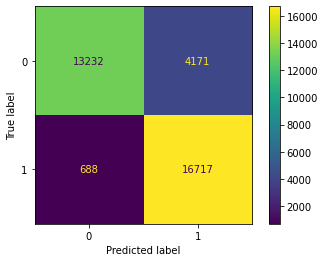

In [83]:
# Results
print("Multinomial Accuracy:", accuracy_score(y_val, y_pred_base_model))
print("\nThe classification report with metrics: \n\n", classification_report(y_val, y_pred_base_model))
cm = confusion_matrix(y_val, y_pred_base_model)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

---------- Ensure predictor is working ----------

Prediction is accurate for these three records by human evaluation.

In [92]:
y_pred_base_model

array([1, 0, 1, ..., 1, 1, 1])

In [93]:
x_val

189704    like prepare future right no serious think sui...
85943     2007 call bitch do ? see miss step bad luck ra...
158847    m ready give life one disappointment another f...
13769     good fashionable store buy clothes love point ...
224794    future career goal ? filler filler filler fill...
                                ...                        
166920                       do m fuck bleed like crazy wow
146894    want live like legend without monster thing m ...
162623    another night alone honestly want kill m sick ...
92625     think know definition pain ? think pimple schlong
19459     suicide hotline hour ? look suicide hotlines c...
Name: text, Length: 34808, dtype: object

In [94]:
x_val[189704]

'like prepare future right no serious think suicide doubt serious think close future either but fear age death almost every day scar day beyond chance make life well best good day behind living regret what if think till fade away hospital bed piss shit pant fuck no not want live long want prepare think end life term way want go place want incredibly afraid life end not live today fuck wrong think ? give actual comfort know way if everything turn bad'

In [95]:
x_val[85943]

'2007 call bitch do ? see miss step bad luck random chance wait parent kick ?'

In [96]:
x_val[158847]

'm ready give life one disappointment another father leave little nt see since apparently real loser anyway mentor abuse almost three year leave real fucked mom yell ignore go way not touch think hate get anxious time never serious girlfriend old sister graduate no longer go live home get horrible grade school last year nt believe god anymore mean point throw towel say enough enough get one life earth u get dealt real shitty hand prolong ? s point living worthless life ? m not immediate risk right but s like even matter ? anyone even care ?'

---------- Ensure predictor is working END ----------

### Correlation

In [18]:
correlation_matrix = np.corrcoef(x_train_transformed, rowvar=False)
correlation_matrix

array([[ 1.00000000e+00,  9.43611545e-01,  9.89363140e-01, ...,
        -1.82582951e-04, -2.53422725e-04, -2.52791452e-04],
       [ 9.43611545e-01,  1.00000000e+00,  9.16794454e-01, ...,
        -1.66734661e-04, -2.31425507e-04, -2.30849029e-04],
       [ 9.89363140e-01,  9.16794454e-01,  1.00000000e+00, ...,
        -1.77972245e-04, -2.47023125e-04, -2.46407794e-04],
       ...,
       [-1.82582951e-04, -1.66734661e-04, -1.77972245e-04, ...,
         1.00000000e+00,  8.39122914e-03, -2.58179584e-04],
       [-2.53422725e-04, -2.31425507e-04, -2.47023125e-04, ...,
         8.39122914e-03,  1.00000000e+00,  4.61412962e-03],
       [-2.52791452e-04, -2.30849029e-04, -2.46407794e-04, ...,
        -2.58179584e-04,  4.61412962e-03,  1.00000000e+00]])

In [21]:
correlation_matrix.shape

(3000, 3000)

In [68]:
correlation_matrix.max()

1.0

In [69]:
correlation_matrix.min()

-0.09578179310059562

In [54]:
# Get columns that are highly correlated

to_drop_cols = []

# Feaures with high correlaion >=0.75
start = 1
for i in range(0,3000):
    for j in range(start, 3000):
        if (j in to_drop_cols):
            continue
        if (correlation_matrix[i][j] >= 0.75):
            to_drop_cols.append(j)
    start = start + 1

In [55]:
len(to_drop_cols)

89

In [56]:
x_train_transformed_dropped = np.delete(x_train_transformed, to_drop_cols, 1)  # delete second row of A
x_train_transformed_dropped.shape

(162439, 2911)

In [57]:
x_val_transformed_dropped = np.delete(x_val_transformed, to_drop_cols, 1)  # delete second row of A
x_val_transformed_dropped.shape

(34808, 2911)

In [58]:
x_test_transformed_dropped = np.delete(x_test_transformed, to_drop_cols, 1)  # delete second row of A
x_test_transformed_dropped.shape

(34809, 2911)

### Model 1

Remove correlated features >=0.75.<br>
False positives decreased decently but False negatives increased by a substantial amount as well.

In [61]:
multi_NB_model1 = MultinomialNB()
multi_NB_model1.fit(x_train_transformed_dropped, y_train)
y_pred_model1 = multi_NB_model1.predict(x_val_transformed_dropped)

Multinomial Accuracy: 0.8738221098598024

The classification report with metrics: 

               precision    recall  f1-score   support

           0       0.95      0.79      0.86     17403
           1       0.82      0.96      0.88     17405

    accuracy                           0.87     34808
   macro avg       0.88      0.87      0.87     34808
weighted avg       0.88      0.87      0.87     34808



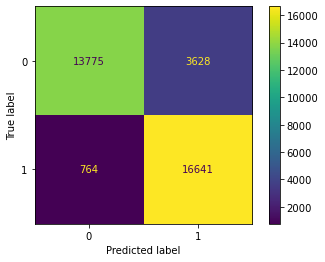

In [65]:
# Results
print("Multinomial Accuracy:", accuracy_score(y_val, y_pred_model1))
print("\nThe classification report with metrics: \n\n", classification_report(y_val, y_pred_model1))
cm = confusion_matrix(y_val, y_pred_model1)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

In [77]:
# Get columns that are highly correlated

to_drop_cols = []

# Feaures with high correlaion >=0.75
start = 1
for i in range(0,3000):
    for j in range(start, 3000):
        if (j in to_drop_cols):y_pred_model2
            continue
        if (correlation_matrix[i][j] >= 0.3):
            to_drop_cols.append(j)
    start = start + 1

In [78]:
len(to_drop_cols)

450

In [79]:
x_train_transformed_dropped = np.delete(x_train_transformed, to_drop_cols, 1)  # delete second row of A
x_train_transformed_dropped.shape

(162439, 2550)

In [80]:
x_val_transformed_dropped = np.delete(x_val_transformed, to_drop_cols, 1)  # delete second row of A
x_val_transformed_dropped.shape

(34808, 2550)

In [81]:
x_test_transformed_dropped = np.delete(x_test_transformed, to_drop_cols, 1)  # delete second row of A
x_test_transformed_dropped.shape

(34809, 2550)

### Model 2

Remove correlated features >=0.3.<br>
General performance of model decreased.

In [82]:
multi_NB_model2 = MultinomialNB()
multi_NB_model2.fit(x_train_transformed_dropped, y_train)
y_pred_model2 = multi_NB_model2.predict(x_val_transformed_dropped)

Multinomial Accuracy: 0.8456676626062974

The classification report with metrics: 

               precision    recall  f1-score   support

           0       0.94      0.73      0.83     17403
           1       0.78      0.96      0.86     17405

    accuracy                           0.85     34808
   macro avg       0.86      0.85      0.84     34808
weighted avg       0.86      0.85      0.84     34808



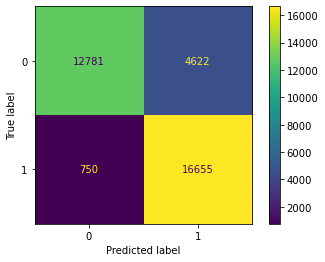

In [83]:
# Results
print("Multinomial Accuracy:", accuracy_score(y_val, y_pred_model2))
print("\nThe classification report with metrics: \n\n", classification_report(y_val, y_pred_model2))
cm = confusion_matrix(y_val, y_pred_model2)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

In [84]:
# Get columns that are highly correlated

to_drop_cols = []

# Feaures with high correlaion >=0.5
start = 1
for i in range(0,3000):
    for j in range(start, 3000):
        if (j in to_drop_cols):
            continue
        if (correlation_matrix[i][j] >= 0.5):
            to_drop_cols.append(j)
    start = start + 1

In [85]:
len(to_drop_cols)

189

In [86]:
x_train_transformed_dropped = np.delete(x_train_transformed, to_drop_cols, 1)  # delete second row of A
x_train_transformed_dropped.shape

(162439, 2811)

In [87]:
x_val_transformed_dropped = np.delete(x_val_transformed, to_drop_cols, 1)  # delete second row of A
x_val_transformed_dropped.shape

(34808, 2811)

In [87]:
x_test_transformed_dropped = np.delete(x_test_transformed, to_drop_cols, 1)  # delete second row of A
x_test_transformed_dropped.shape

(34808, 2811)

### Model 3

Remove correlated features >=0.5.<br>
False positives decreased decently but False negatives increased slightly.

In [89]:
multi_NB_model3 = MultinomialNB()
multi_NB_model3.fit(x_train_transformed_dropped, y_train)
y_pred_model3 = multi_NB_model3.predict(x_val_transformed_dropped)

Multinomial Accuracy: 0.869943691105493

The classification report with metrics: 

               precision    recall  f1-score   support

           0       0.95      0.78      0.86     17403
           1       0.81      0.96      0.88     17405

    accuracy                           0.87     34808
   macro avg       0.88      0.87      0.87     34808
weighted avg       0.88      0.87      0.87     34808



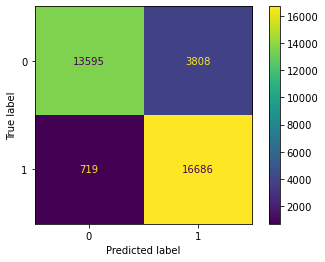

In [90]:
# Results
print("Multinomial Accuracy:", accuracy_score(y_val, y_pred_model3))
print("\nThe classification report with metrics: \n\n", classification_report(y_val, y_pred_model3))
cm = confusion_matrix(y_val, y_pred_model3)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

### Model 3 (Test Results)

For our problem of detecting suicide cases, wrongly prediciting a negative case as positive (false positive) is much more acceptable than wrongly prediciting a positive case as negative (false negative). In short, we want to detect as many actual suicide text as possible, even if it means predicting some normal texts wrongly as suicide texts.

From this context, model 3 is chosen because it is a slightly better model than the base model with 0.01 higher precision for predicting suicide texts while maintining a recall of 0.96. Although the number of false negatives is slightly higher for Model 3, it was not significant enough to impact the recall score. We think that the increase in precision and minute decrease in recall is worth it because false positives hog resources as well (manpower...).

Multinomial Accuracy: 0.869229222327559

The classification report with metrics: 

               precision    recall  f1-score   support

           0       0.95      0.78      0.86     17404
           1       0.81      0.96      0.88     17405

    accuracy                           0.87     34809
   macro avg       0.88      0.87      0.87     34809
weighted avg       0.88      0.87      0.87     34809



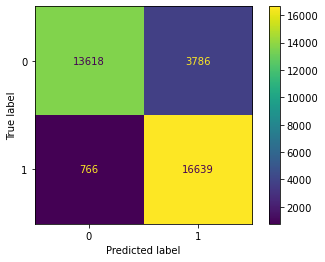

In [91]:
# Results
y_test_pred_model3 = multi_NB_model3.predict(x_test_transformed_dropped)

print("Multinomial Accuracy:", accuracy_score(y_test, y_test_pred_model3))
print("\nThe classification report with metrics: \n\n", classification_report(y_test, y_test_pred_model3))
cm = confusion_matrix(y_test, y_test_pred_model3)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

## LSTM (Neural Network)

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Embedding, Dropout

### Preprocessing

In [3]:
# Read dataset from csv file
df_lstm = pd.read_csv("../Dataset/Suicide_Detection(After Lemmitization).csv")
df_lstm

,text,class
0,ex wife threaten suicide recently leave wife g...,suicide
1,weird nt get affect compliment if s come someo...,non-suicide
2,finally 2020 almost never hear 2020 bad year e...,non-suicide
3,need helpjust help im cry hard,suicide
4,lose hello name adam 16 struggle year afraid p...,suicide
...,...,...
232051,if nt like rock not go get anything but go htt...,non-suicide
232052,tell many friend not lonely everything deprive...,non-suicide
232053,pee probably taste like salty tea smirk face s...,non-suicide
232054,usual stuff find m not post sympathy pity beca...,suicide


### Glove Word Embedding

In [4]:
# Get word embedding dictionary; word as Key, vector as Value
embeddings_dict = {}
with open("../Dataset/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [5]:
len(embeddings_dict['the'])

50

### Label Encoder (class/y)

In [6]:
# Encode sentiment labels
from sklearn.preprocessing import LabelEncoder
labels = df_lstm["class"].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
print(encoded_labels)
print("No. of Records: ", len(encoded_labels))

[1 0 0 ... 0 1 0]
No. of Records:  232056


### Split Data

Split data into Train, Val, Test: 70%, 15%, 15%.

In [7]:
# Split into train, remain, with stratify to maintain class proportion for each set
x_train, x_remain, y_train, y_remain = train_test_split(df_lstm["text"], encoded_labels, stratify = encoded_labels, 
                                                    train_size=0.7, random_state=88)
print("x_train shape: ", x_train.shape)
print("x_remain shape: ", x_remain.shape)
print("y_train shape: ", y_train.shape)
print("y_remain shape: ", y_remain.shape)

x_train shape:  (162439,)
x_remain shape:  (69617,)
y_train shape:  (162439,)
y_remain shape:  (69617,)


In [8]:
# Split into val, test
x_val, x_test, y_val, y_test = train_test_split(x_remain, y_remain, stratify = y_remain, 
                                                    train_size=0.5, random_state=88)
print("x_val shape: ", x_val.shape)
print("x_test shape: ", x_test.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)

x_val shape:  (34808,)
x_test shape:  (34809,)
y_val shape:  (34808,)
y_test shape:  (34809,)


### Tokenize Texts

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)

x_train = word_tokenizer.texts_to_sequences(x_train)
x_val = word_tokenizer.texts_to_sequences(x_val)
x_test = word_tokenizer.texts_to_sequences(x_test)

In [10]:
len(word_tokenizer.word_index)

140921

In [11]:
vocab_length = len(word_tokenizer.word_index) + 1

In [12]:
# Pad Sequences
maxlen = 100
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_val = pad_sequences(x_val, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [13]:
len(x_train[211])

100

### Embedding Matrix

In [14]:
embedding_matrix = np.zeros((vocab_length, 50))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [15]:
embedding_matrix.shape

(140922, 50)

### Base Model

In [16]:
lstm_model_base = Sequential()

lstm_model_base.add(Embedding(vocab_length, 50, weights=[embedding_matrix], 
                    input_length=maxlen , trainable=False))

lstm_model_base.add(LSTM(128, return_sequences=False))
                    
lstm_model_base.add(Dense(1, activation='sigmoid'))
                    
lstm_model_base.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm_model_base.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           7046100   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               91648     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 7,137,877
Trainable params: 91,777
Non-trainable params: 7,046,100
_________________________________________________________________
None


In [18]:
lstm_model_base_history = lstm_model_base.fit(x_train, y_train, validation_data=(x_val, y_val),
               epochs=20, batch_size=32, verbose=1)

lstm_model_base.save("lstm_base.h5")

Epoch 1/20
5077/5077 [==============================] - 61s 12ms/step - loss: 0.0658 - accuracy: 0.9777 - val_loss: 0.2910 - val_accuracy: 0.9186
Epoch 2/20
5077/5077 [==============================] - 61s 12ms/step - loss: 0.0628 - accuracy: 0.9790 - val_loss: 0.2976 - val_accuracy: 0.9192
Epoch 3/20
5077/5077 [==============================] - 62s 12ms/step - loss: 0.0565 - accuracy: 0.9814 - val_loss: 0.3243 - val_accuracy: 0.9168
Epoch 4/20
5077/5077 [==============================] - 60s 12ms/step - loss: 0.0546 - accuracy: 0.9817 - val_loss: 0.3201 - val_accuracy: 0.9179
Epoch 5/20
5077/5077 [==============================] - 60s 12ms/step - loss: 0.0505 - accuracy: 0.9832 - val_loss: 0.3183 - val_accuracy: 0.9158
Epoch 6/20
5077/5077 [==============================] - 60s 12ms/step - loss: 0.0483 - accuracy: 0.9841 - val_loss: 0.3331 - val_accuracy: 0.9165
Epoch 7/20
5077/5077 [==============================] - 60s 12ms/step - loss: 0.0462 - accuracy: 0.9850 - val_loss: 0.3489 -

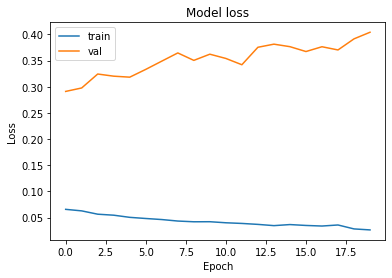

In [19]:
plt.plot(lstm_model_base_history.history['loss'])
plt.plot(lstm_model_base_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [51]:
lstm_model_base_y_pred = lstm_model_base.predict(x_val)

In [57]:
lstm_model_base_y_pred_new = []
for prediction in lstm_model_base_y_pred:
    if prediction >= 0.5:
        lstm_model_base_y_pred_new.append(1)
    else:
        lstm_model_base_y_pred_new.append(0)

In [59]:
lstm_model_base_y_pred_new = np.array(lstm_model_base_y_pred_new)
lstm_model_base_y_pred_new.shape

(34808,)

LSTM Accuracy: 0.9146747874051943

The classification report with metrics: 

               precision    recall  f1-score   support

           0       0.91      0.93      0.92     17403
           1       0.92      0.90      0.91     17405

    accuracy                           0.91     34808
   macro avg       0.91      0.91      0.91     34808
weighted avg       0.91      0.91      0.91     34808



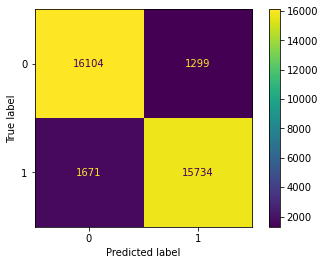

In [61]:
# Results
print("LSTM Accuracy:", accuracy_score(y_val, lstm_model_base_y_pred_new))
print("\nThe classification report with metrics: \n\n", classification_report(y_val, lstm_model_base_y_pred_new))
cm = confusion_matrix(y_val, lstm_model_base_y_pred_new)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

### Model 1

Increase LSTM layers, add dropout.

In [66]:
lstm_model_1 = Sequential()

lstm_model_1.add(Embedding(vocab_length, 50, weights=[embedding_matrix], 
                    input_length=maxlen, trainable=False))

lstm_model_1.add(LSTM(60, return_sequences=True))

lstm_model_1.add(Dropout(0.2))

lstm_model_1.add(LSTM(60, return_sequences=False))

lstm_model_1.add(Dense(1, activation='sigmoid'))
                    
lstm_model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm_model_1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           7046100   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 60)           26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 60)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 7,101,841
Trainable params: 55,741
Non-trainable params: 7,046,100
_________________________________________________________________
None


In [67]:
lstm_model_1_history = lstm_model_1.fit(x_train, y_train, validation_data=(x_val, y_val),
               epochs=20, batch_size=32, verbose=1)

lstm_model_1.save("lstm_model1.h5")

Epoch 1/20
5077/5077 [==============================] - 103s 20ms/step - loss: 0.3552 - accuracy: 0.8504 - val_loss: 0.2727 - val_accuracy: 0.8910
Epoch 2/20
5077/5077 [==============================] - 99s 20ms/step - loss: 0.2543 - accuracy: 0.9005 - val_loss: 0.2463 - val_accuracy: 0.9019
Epoch 3/20
5077/5077 [==============================] - 99s 19ms/step - loss: 0.2200 - accuracy: 0.9145 - val_loss: 0.2154 - val_accuracy: 0.9180
Epoch 4/20
5077/5077 [==============================] - 99s 19ms/step - loss: 0.2045 - accuracy: 0.9213 - val_loss: 0.2020 - val_accuracy: 0.9227
Epoch 5/20
5077/5077 [==============================] - 99s 20ms/step - loss: 0.1916 - accuracy: 0.9266 - val_loss: 0.2217 - val_accuracy: 0.9137
Epoch 6/20
5077/5077 [==============================] - 100s 20ms/step - loss: 0.1803 - accuracy: 0.9313 - val_loss: 0.1949 - val_accuracy: 0.9250
Epoch 7/20
5077/5077 [==============================] - 99s 19ms/step - loss: 0.1722 - accuracy: 0.9353 - val_loss: 0.1948

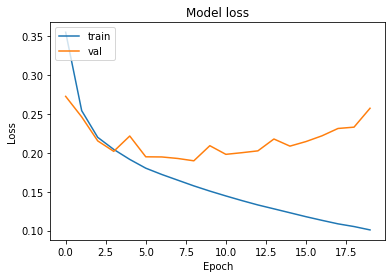

In [68]:
plt.plot(lstm_model_1_history.history['loss'])
plt.plot(lstm_model_1_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [69]:
lstm_model_1_y_pred = lstm_model_1.predict(x_val)

In [70]:
lstm_model_1_y_pred_new = []
for prediction in lstm_model_1_y_pred:
    if prediction >= 0.5:
        lstm_model_1_y_pred_new.append(1)
    else:
        lstm_model_1_y_pred_new.append(0)

In [71]:
lstm_model_1_y_pred_new = np.array(lstm_model_1_y_pred_new)
lstm_model_1_y_pred_new.shape

(34808,)

LSTM Accuracy: 0.9180648126867387

The classification report with metrics: 

               precision    recall  f1-score   support

           0       0.89      0.95      0.92     17403
           1       0.94      0.89      0.92     17405

    accuracy                           0.92     34808
   macro avg       0.92      0.92      0.92     34808
weighted avg       0.92      0.92      0.92     34808



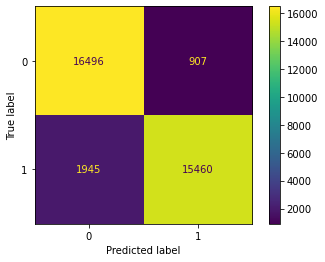

In [72]:
# Results
print("LSTM Accuracy:", accuracy_score(y_val, lstm_model_1_y_pred_new))
print("\nThe classification report with metrics: \n\n", classification_report(y_val, lstm_model_1_y_pred_new))
cm = confusion_matrix(y_val, lstm_model_1_y_pred_new)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

### Model 2

Increase LSTM layers, add dropout.

In [73]:
lstm_model_2 = Sequential()

lstm_model_2.add(Embedding(vocab_length, 50, weights=[embedding_matrix], 
                    input_length=maxlen, trainable=False))

lstm_model_2.add(LSTM(32, return_sequences=True))

lstm_model_2.add(Dropout(0.2))

lstm_model_2.add(LSTM(32, return_sequences=False))

lstm_model_2.add(Dense(1, activation='sigmoid'))
                    
lstm_model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm_model_2.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           7046100   
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 32)           10624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 7,065,077
Trainable params: 18,977
Non-trainable params: 7,046,100
_________________________________________________________________
None


In [74]:
lstm_model_2_history = lstm_model_2.fit(x_train, y_train, validation_data=(x_val, y_val),
               epochs=20, batch_size=32, verbose=1)

lstm_model_2.save("lstm_model2.h5")

Epoch 1/20
5077/5077 [==============================] - 105s 21ms/step - loss: 0.2910 - accuracy: 0.8840 - val_loss: 0.2445 - val_accuracy: 0.9047
Epoch 2/20
5077/5077 [==============================] - 105s 21ms/step - loss: 0.2286 - accuracy: 0.9126 - val_loss: 0.2150 - val_accuracy: 0.9180
Epoch 3/20
5077/5077 [==============================] - 104s 21ms/step - loss: 0.2118 - accuracy: 0.9185 - val_loss: 0.2111 - val_accuracy: 0.9187
Epoch 4/20
5077/5077 [==============================] - 104s 21ms/step - loss: 0.2011 - accuracy: 0.9232 - val_loss: 0.2032 - val_accuracy: 0.9219
Epoch 5/20
5077/5077 [==============================] - 104s 21ms/step - loss: 0.1940 - accuracy: 0.9258 - val_loss: 0.2020 - val_accuracy: 0.9228
Epoch 6/20
5077/5077 [==============================] - 104s 21ms/step - loss: 0.1872 - accuracy: 0.9283 - val_loss: 0.1980 - val_accuracy: 0.9259
Epoch 7/20
5077/5077 [==============================] - 104s 21ms/step - loss: 0.1816 - accuracy: 0.9305 - val_loss: 0

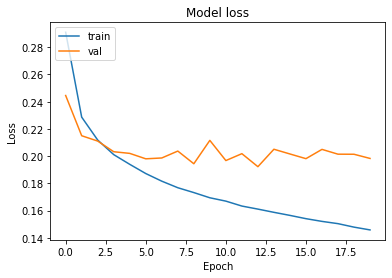

In [76]:
plt.plot(lstm_model_2_history.history['loss'])
plt.plot(lstm_model_2_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [77]:
lstm_model_2_y_pred = lstm_model_2.predict(x_val)

In [78]:
lstm_model_2_y_pred_new = []
for prediction in lstm_model_2_y_pred:
    if prediction >= 0.5:
        lstm_model_2_y_pred_new.append(1)
    else:
        lstm_model_2_y_pred_new.append(0)

In [79]:
lstm_model_2_y_pred_new = np.array(lstm_model_2_y_pred_new)
lstm_model_2_y_pred_new.shape

(34808,)

LSTM Accuracy: 0.9255630889450701

The classification report with metrics: 

               precision    recall  f1-score   support

           0       0.93      0.92      0.93     17403
           1       0.92      0.93      0.93     17405

    accuracy                           0.93     34808
   macro avg       0.93      0.93      0.93     34808
weighted avg       0.93      0.93      0.93     34808



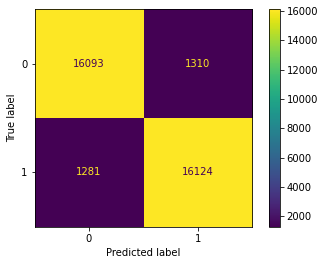

In [80]:
# Results
print("LSTM Accuracy:", accuracy_score(y_val, lstm_model_2_y_pred_new))
print("\nThe classification report with metrics: \n\n", 
      classification_report(y_val, lstm_model_2_y_pred_new))
cm = confusion_matrix(y_val, lstm_model_2_y_pred_new)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

### Model 3

Add L2 Regularizer.

In [86]:
lstm_model_3 = Sequential()

lstm_model_3.add(Embedding(vocab_length, 50, weights=[embedding_matrix], 
                    input_length=maxlen, trainable=False))

lstm_model_3.add(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001)))

lstm_model_3.add(Dropout(0.2))

lstm_model_3.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)))

lstm_model_3.add(Dense(1, activation='sigmoid'))
                    
lstm_model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm_model_3.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 50)           7046100   
_________________________________________________________________
lstm_8 (LSTM)                (None, 100, 32)           10624     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 7,065,077
Trainable params: 18,977
Non-trainable params: 7,046,100
_________________________________________________________________
None


In [87]:
lstm_model_3_history = lstm_model_3.fit(x_train, y_train, validation_data=(x_val, y_val),
               epochs=20, batch_size=32, verbose=1)

lstm_model_3.save("lstm_model3.h5")

Epoch 1/20
5077/5077 [==============================] - 107s 21ms/step - loss: 0.3913 - accuracy: 0.8503 - val_loss: 0.3060 - val_accuracy: 0.8890
Epoch 2/20
5077/5077 [==============================] - 107s 21ms/step - loss: 0.2858 - accuracy: 0.8970 - val_loss: 0.2756 - val_accuracy: 0.9029
Epoch 3/20
5077/5077 [==============================] - 107s 21ms/step - loss: 0.2657 - accuracy: 0.9055 - val_loss: 0.2905 - val_accuracy: 0.8959
Epoch 4/20
5077/5077 [==============================] - 106s 21ms/step - loss: 0.2572 - accuracy: 0.9085 - val_loss: 0.2521 - val_accuracy: 0.9123
Epoch 5/20
5077/5077 [==============================] - 106s 21ms/step - loss: 0.2515 - accuracy: 0.9111 - val_loss: 0.2468 - val_accuracy: 0.9136
Epoch 6/20
5077/5077 [==============================] - 107s 21ms/step - loss: 0.2482 - accuracy: 0.9130 - val_loss: 0.2575 - val_accuracy: 0.9100
Epoch 7/20
5077/5077 [==============================] - 106s 21ms/step - loss: 0.2461 - accuracy: 0.9139 - val_loss: 0

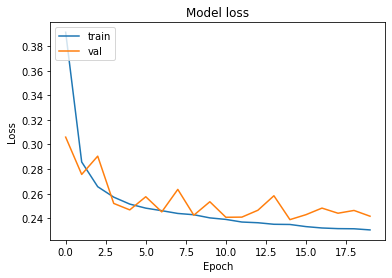

In [88]:
plt.plot(lstm_model_3_history.history['loss'])
plt.plot(lstm_model_3_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [89]:
lstm_model_3_y_pred = lstm_model_3.predict(x_val)

In [90]:
lstm_model_3_y_pred_new = []
for prediction in lstm_model_3_y_pred:
    if prediction >= 0.5:
        lstm_model_3_y_pred_new.append(1)
    else:
        lstm_model_3_y_pred_new.append(0)

In [91]:
lstm_model_3_y_pred_new = np.array(lstm_model_3_y_pred_new)
lstm_model_3_y_pred_new.shape

(34808,)

LSTM Accuracy: 0.9164847161572053

The classification report with metrics: 

               precision    recall  f1-score   support

           0       0.93      0.90      0.92     17403
           1       0.90      0.93      0.92     17405

    accuracy                           0.92     34808
   macro avg       0.92      0.92      0.92     34808
weighted avg       0.92      0.92      0.92     34808



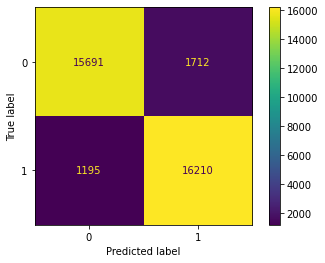

In [92]:
# Results
print("LSTM Accuracy:", accuracy_score(y_val, lstm_model_3_y_pred_new))
print("\nThe classification report with metrics: \n\n", 
      classification_report(y_val, lstm_model_3_y_pred_new))
cm = confusion_matrix(y_val, lstm_model_3_y_pred_new)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

### Model 4

Add L2 Regularizer.

In [93]:
lstm_model_4 = Sequential()

lstm_model_4.add(Embedding(vocab_length, 50, weights=[embedding_matrix], 
                    input_length=maxlen, trainable=False))

lstm_model_4.add(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001)))

lstm_model_4.add(Dropout(0.2))

lstm_model_4.add(LSTM(48, return_sequences=True, kernel_regularizer=l2(0.001)))

lstm_model_4.add(Dropout(0.2))

lstm_model_4.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)))

lstm_model_4.add(Dense(1, activation='sigmoid'))
                    
lstm_model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm_model_4.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 50)           7046100   
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 32)           10624     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100, 48)           15552     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 48)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                10368     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [94]:
lstm_model_4_history = lstm_model_4.fit(x_train, y_train, validation_data=(x_val, y_val),
               epochs=20, batch_size=32, verbose=1)

lstm_model_4.save("lstm_model4.h5")

Epoch 1/20
5077/5077 [==============================] - 157s 31ms/step - loss: 0.3859 - accuracy: 0.8529 - val_loss: 0.2985 - val_accuracy: 0.8940
Epoch 2/20
5077/5077 [==============================] - 154s 30ms/step - loss: 0.2863 - accuracy: 0.8964 - val_loss: 0.2756 - val_accuracy: 0.8988
Epoch 3/20
5077/5077 [==============================] - 155s 31ms/step - loss: 0.2700 - accuracy: 0.9031 - val_loss: 0.2560 - val_accuracy: 0.9100
Epoch 4/20
5077/5077 [==============================] - 154s 30ms/step - loss: 0.2607 - accuracy: 0.9079 - val_loss: 0.2628 - val_accuracy: 0.9085
Epoch 5/20
5077/5077 [==============================] - 154s 30ms/step - loss: 0.2555 - accuracy: 0.9101 - val_loss: 0.2558 - val_accuracy: 0.9111
Epoch 6/20
5077/5077 [==============================] - 154s 30ms/step - loss: 0.2523 - accuracy: 0.9109 - val_loss: 0.2574 - val_accuracy: 0.9068
Epoch 7/20
5077/5077 [==============================] - 155s 30ms/step - loss: 0.2546 - accuracy: 0.9113 - val_loss: 0

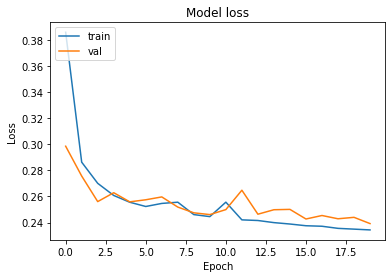

In [95]:
plt.plot(lstm_model_4_history.history['loss'])
plt.plot(lstm_model_4_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

In [96]:
lstm_model_4_y_pred = lstm_model_4.predict(x_val)

In [97]:
lstm_model_4_y_pred_new = []
for prediction in lstm_model_4_y_pred:
    if prediction >= 0.5:
        lstm_model_4_y_pred_new.append(1)
    else:
        lstm_model_4_y_pred_new.append(0)

In [98]:
lstm_model_4_y_pred_new = np.array(lstm_model_4_y_pred_new)
lstm_model_4_y_pred_new.shape

(34808,)

LSTM Accuracy: 0.9172603999080671

The classification report with metrics: 

               precision    recall  f1-score   support

           0       0.91      0.92      0.92     17403
           1       0.92      0.91      0.92     17405

    accuracy                           0.92     34808
   macro avg       0.92      0.92      0.92     34808
weighted avg       0.92      0.92      0.92     34808



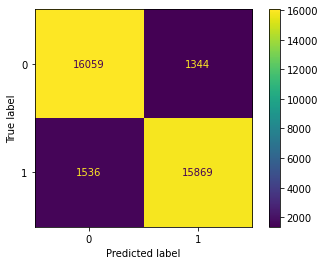

In [99]:
# Results
print("LSTM Accuracy:", accuracy_score(y_val, lstm_model_4_y_pred_new))
print("\nThe classification report with metrics: \n\n", 
      classification_report(y_val, lstm_model_4_y_pred_new))
cm = confusion_matrix(y_val, lstm_model_4_y_pred_new)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

## Logistics regression

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
file_path = 'Suicide_Detection(After Embeddings).csv'
df = pd.read_csv(file_path)


FileNotFoundError: [Errno 2] No such file or directory: 'Suicide_Detection(After Embeddings).csv'

### Embedding and splitting of data

In [ ]:
def parse_embedding(embedding_str):
    return np.array([float(x) for x in embedding_str.strip('[]').split(',')])

df['embeddings'] = df['embeddings'].apply(parse_embedding)

label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

train_embeddings, temp_embeddings, train_labels, temp_labels = train_test_split(
    np.stack(df['embeddings'].values), df['class'], test_size=0.3, random_state=88)

val_embeddings, test_embeddings, val_labels, test_labels = train_test_split(
    temp_embeddings, temp_labels, test_size=0.5, random_state=88)


### Model

In [4]:
clf = LogisticRegression(max_iter=1000)
clf.fit(train_embeddings, train_labels)

test_predictions = clf.predict(test_embeddings)

print("Test Set Classification Report:")
print(classification_report(test_labels, test_predictions))


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     17363
           1       0.91      0.92      0.91     17446

    accuracy                           0.91     34809
   macro avg       0.91      0.91      0.91     34809
weighted avg       0.91      0.91      0.91     34809



### Sample prediction

In [5]:
sample_index = 0 
sample_embedding = test_embeddings[sample_index].reshape(1, -1)
sample_prediction = clf.predict(sample_embedding)

print(f"Sample Prediction for test data point at index {sample_index}: {label_encoder.inverse_transform(sample_prediction)[0]}")

Sample Prediction for test data point at index 0: suicide


## Gradient Boosting Machine

In [15]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

### Label Encoder

In [17]:
df = pd.read_csv("Suicide_Detection.csv")

# Encode sentiment labels
from sklearn.preprocessing import LabelEncoder
labels = df["class"].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

print(encoded_labels)
print("No. of Records: ", len(encoded_labels))

[1 0 0 ... 0 1 0]
No. of Records:  232056


### Split Data

In [20]:
# Split into train, remain, with stratify to maintain class proportion for each set
x_train, x_remain, y_train, y_remain = train_test_split(df["text"], encoded_labels, stratify = encoded_labels, 
                                                    train_size=0.7, random_state=88)

# Print the shapes of the splits
print("x_train shape: ", x_train.shape)
print("x_remain shape: ", x_remain.shape)
print("y_train shape: ", y_train.shape)
print("y_remain shape: ", y_remain.shape)

x_train shape:  (162439,)
x_remain shape:  (69617,)
y_train shape:  (162439,)
y_remain shape:  (69617,)


In [22]:
# Split into val, test
x_val, x_test, y_val, y_test = train_test_split(x_remain, y_remain, stratify = y_remain, 
                                                    train_size=0.5, random_state=88)
print("x_val shape: ", x_val.shape)
print("x_test shape: ", x_test.shape)
print("y_val shape: ", y_val.shape)
print("y_test shape: ", y_test.shape)

x_val shape:  (34808,)
x_test shape:  (34809,)
y_val shape:  (34808,)
y_test shape:  (34809,)


### Data Vectorization

In [25]:
# Create matrix based on word frequency
vectorizer = TfidfVectorizer(max_features=5000)
x_train_transformed = vectorizer.fit_transform(x_train)
x_val_transformed = vectorizer.transform(x_val)
x_test_transformed = vectorizer.transform(x_test)

In [26]:
print("x train transformed shape: ", x_train_transformed.toarray().shape)
print("x val transformed shape: ", x_val_transformed.toarray().shape)
print("x test transformed shape: ", x_test_transformed.toarray().shape)

x train transformed shape:  (162439, 5000)
x val transformed shape:  (34808, 5000)
x test transformed shape:  (34809, 5000)


In [27]:
len(vectorizer.vocabulary_)
vectorizer.vocabulary_

{'need': 2924,
 'help': 2097,
 'get': 1919,
 'depressed': 1211,
 'thinking': 4443,
 'past': 3202,
 'wife': 4881,
 'meet': 2755,
 'high': 2116,
 'school': 3837,
 'sophomore': 4108,
 'year': 4970,
 'great': 1983,
 'senior': 3889,
 'break': 662,
 'because': 509,
 'want': 4802,
 'hang': 2038,
 'friend': 1836,
 'felt': 1700,
 'like': 2580,
 'clingy': 885,
 'start': 4185,
 'talk': 4355,
 'little': 2598,
 'but': 723,
 'stage': 4175,
 'would': 4938,
 'go': 1942,
 'guy': 2014,
 'make': 2679,
 'jealous': 2422,
 'told': 4500,
 'later': 2511,
 'back': 447,
 'together': 4496,
 'could': 1050,
 'commit': 941,
 'relationship': 3635,
 'fast': 1673,
 'forward': 1807,
 'seven': 3906,
 'present': 3402,
 'marry': 2708,
 'old': 3071,
 'time': 4479,
 'tell': 4387,
 'indeed': 2290,
 'sleep': 4029,
 'mine': 2802,
 'shock': 3949,
 'ca': 732,
 'nt': 3007,
 'stop': 4216,
 'picture': 3276,
 'mind': 2800,
 'image': 2249,
 'two': 4606,
 'sex': 3910,
 'since': 3996,
 'date': 1149,
 'young': 4984,
 'never': 2946,
 're

### Base Model

In [29]:
gbc = GradientBoostingClassifier()
gbc.fit(x_train_transformed, y_train)

# Make predictions
y_pred_base_model = gbc.predict(x_val_transformed)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred_base_model)
report = classification_report(y_val, y_pred_base_model)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8858021144564467
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     17403
           1       0.92      0.85      0.88     17405

    accuracy                           0.89     34808
   macro avg       0.89      0.89      0.89     34808
weighted avg       0.89      0.89      0.89     34808



True Positives: 14803
True Negatives: 16030
False Positives: 1373
False Negatives: 2602
True Positive Rate: 0.8505027291008331
True Negative Rate: 0.9211055565132449


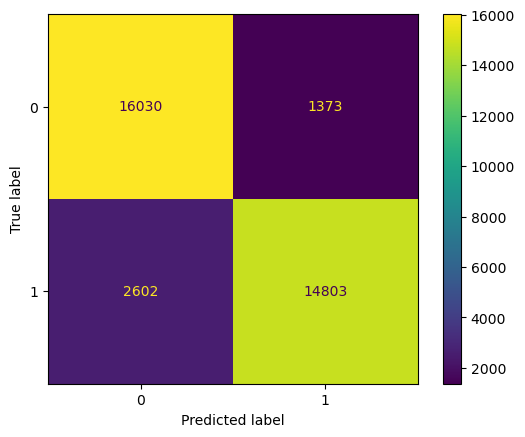

In [30]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm)
    display.plot()
    
    # Calculate TP, TN, FP, FN
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    return TP, TN, FP, FN, TPR, TNR

# Plot confusion matrix for each model
TP, TN, FP, FN, TPR, TNR = plot_confusion_matrix(y_val, y_pred_base_model, title='Confusion Matrix')
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positive Rate:", TPR)
print("True Negative Rate:", TNR)

### Hyperparameter tunning

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(x_train_transformed, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred_best_model = best_model.predict(x_val_transformed)

# Evaluate the best model
accuracy_best = accuracy_score(y_val, y_pred_best_model)
report_best = classification_report(y_val, y_pred_best_model)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {accuracy_best}")
print("Best Classification Report:")
print(report_best)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best Accuracy: 0.8974948287749942
Best Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     17403
           1       0.92      0.87      0.89     17405

    accuracy                           0.90     34808
   macro avg       0.90      0.90      0.90     34808
weighted avg       0.90      0.90      0.90     34808

